In [1]:
import numpy as np
from sigvisa import Sigvisa

from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, TimeRangeRunSpec, do_coarse_to_fine, initialize_from, do_inference, initialize_sg
from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.treegp.gp import GPCov
from sigvisa.graph.region import Region

import cPickle as pickle

from sigvisa.utils.geog import dist_km

%matplotlib inline
import matplotlib.pylab as plt

from sigvisa.signals.common import Waveform

from sigvisa.explore.correlate_validation_events import load_arrivals
from sigvisa.explore.correlate_validation_events_align import build_sg, proposal_xc, locate_event, get_prior_nm

from sigvisa.infer.correlations.weighted_event_posterior import hack_ev_time_posterior_with_weight, compute_atime_posteriors
from sigvisa.infer.correlations.historical_signal_library import get_historical_signals
from sigvisa.infer.correlations.event_proposal import compute_proposal_distribution

In [2]:
# build a timespec SG with the first hour of Wells validation data

def build_sg(stas, stime, etime):

    runid = 17
    hz=10.0
    uatemplate_rate=4e-4
    bands=["freq_0.8_4.5"]
    phases=["Pn", "Sn", "Lg", "Pg"]
    hack_constraint = True
    raw_signals = True

    region_lon = (-126, -100)
    region_lat = (32, 49)

    region_stime = stime
    region_etime = etime

    runids=(runid,)

    rs = TimeRangeRunSpec(sites=stas, start_time=region_stime, end_time=region_etime)

    region_stime = rs.start_time
    region_etime = rs.end_time
    region = Region(lons=region_lon, lats=region_lat,
                    times=(region_stime, region_etime),
                    rate_bulletin="isc",
                    min_mb=2.0,
                    rate_train_start=1167609600,
                    rate_train_end=1199145600)


    ms1 = ModelSpec(template_model_type="gpparam",
                    wiggle_family="db4_2.0_3_20.0",
                    wiggle_model_type="gplocal+lld+none",
                    uatemplate_rate=uatemplate_rate,
                    max_hz=hz,
                    phases=phases,
                    bands=bands,
                    runids=runids,
                    inference_region=region,
                    dummy_fallback=False,
                    raw_signals=raw_signals,
                    hack_param_constraint=hack_constraint,
                    vert_only=True)

    sg = rs.build_sg(ms1)
    return sg

In [3]:
stime = 1203624962 
etime = 1203628562

#stas = "ANMO,ELK,ILAR,KDAK,NEW,NVAR,PDAR,PFO,TXAR,ULM,YBH,YKA".split(",")
stas = ["NVAR",]
phases=["Pn", "Sn", "Lg", "Pg"]
sg = build_sg(stas, stime, etime)

loading sta NVAR chan auto time [1203624962.0, 1203629062.0]  ... successfully loaded.


In [4]:
def plot_signal_with_alignments(s, stitle, *args):
    
    colors = ("blue", "green", "red")
    
    assert( len(args) % 3 == 0)
    n_alignments = len(args) / 3
    
    f = plt.figure(figsize=(15, 10))
    
    ax1 = f.add_subplot(n_alignments+1,1,1)    
    ax1.plot(s, color="black", linewidth=0.5, alpha=0.5)
    ax1.set_title(stitle)

    for i in range(n_alignments):
        align_signal, align_idx, align_title = args[i*3:i*3+3]
        color = colors[i]
        ax = f.add_subplot(n_alignments+1,1,i+2)    
        ax.plot(align_signal, color=color, linewidth=3)
        
        relevant_signal = s[align_idx:align_idx+len(align_signal)].copy()
        relevant_signal /= np.max(relevant_signal) / np.max(align_signal)
        #print len(relevant_signal)
        ax.plot(relevant_signal , color="black", alpha=0.5)
        
        scaled_align_signal = align_signal * np.max(align_signal)  / np.max(relevant_signal)
        #print len(align_signal)
        #print len(relevant_signal)
        #print scaled_align_signal
        ax1.plot(np.arange(align_idx, align_idx+len(align_signal)), scaled_align_signal, color=color)
        
        ax.set_title(align_title)


In [6]:
proposals = get_historical_signals(sg)


/home/dmoore/python/sigvisa/infer/correlations/weighted_event_posterior.py:87: RuntimeWarning: divide by zero encountered in log
  origin_ll = np.log(rr) + llmax


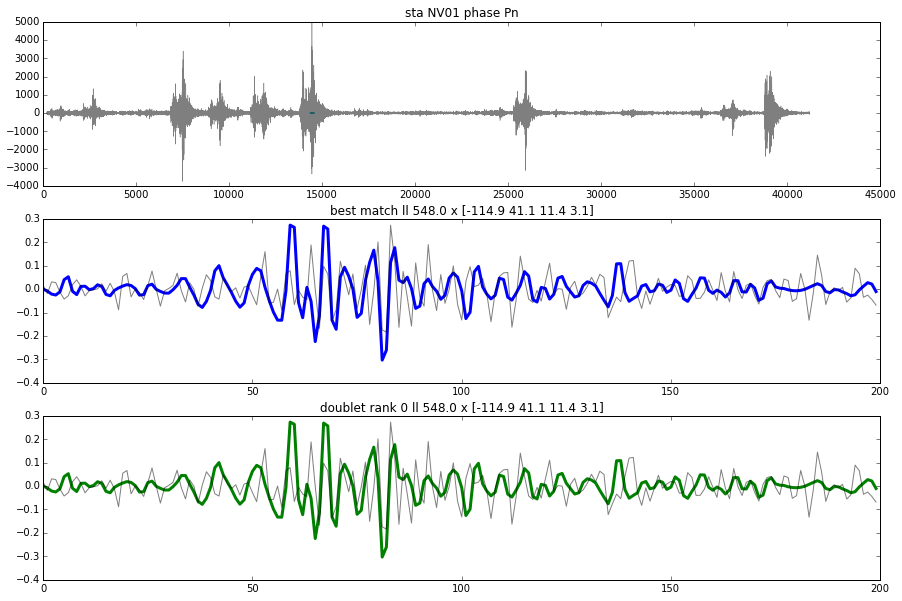

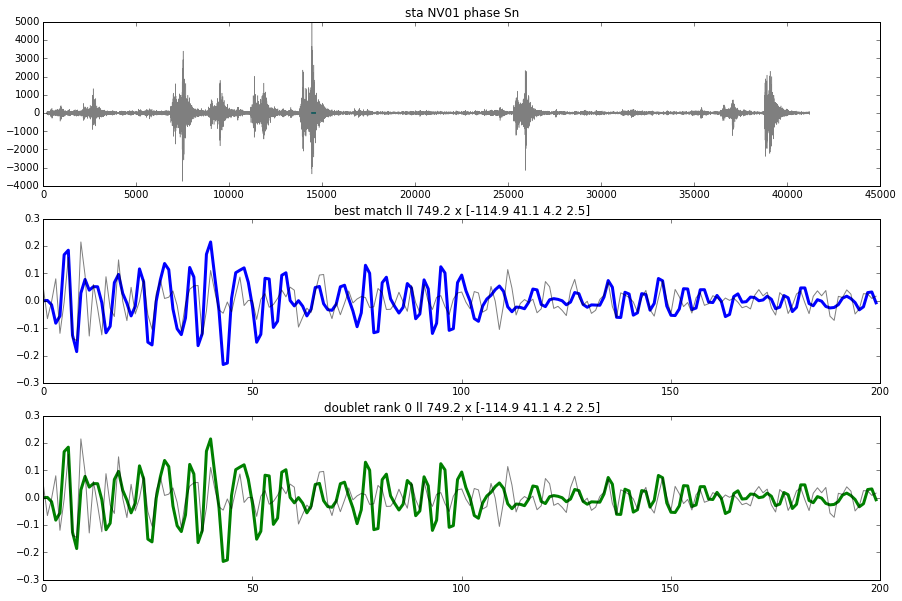

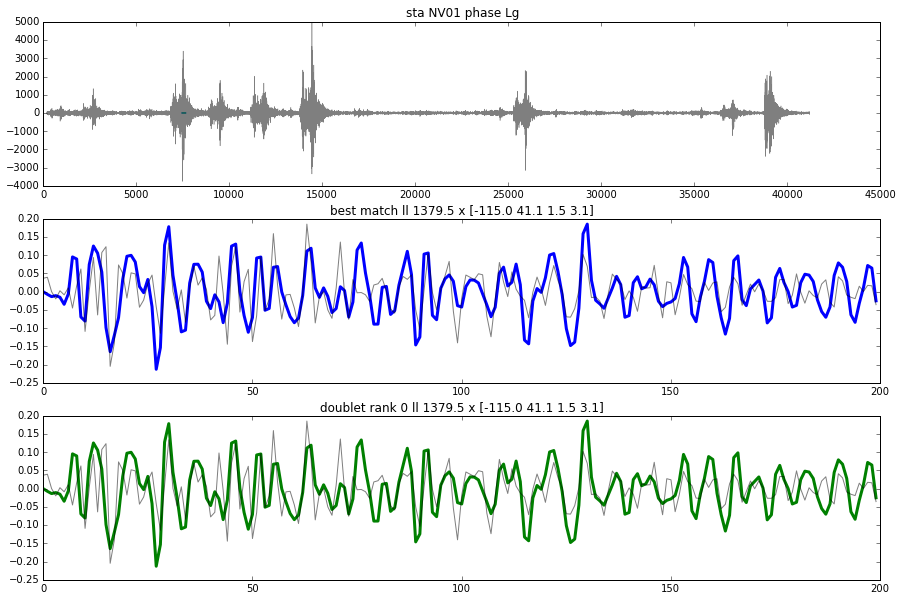

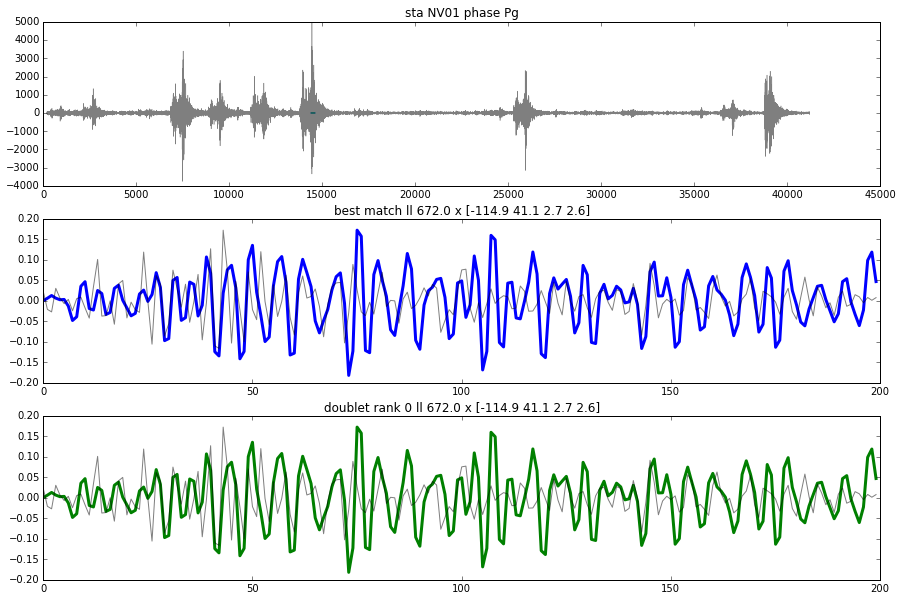

In [7]:
s = Sigvisa()

def fmt_x(x):
    return ("[%.1f %.1f %.1f %.1f]" % (x[0,0], x[0,1], x[0,2], x[0,4]))

global_srate = 1.0 # granularity at which to make atime proposals, NOT
                       # tied to the srate of any particular signal
global_stime = sg.inference_region.stime
global_etime = sg.inference_region.etime
N = int((sg.inference_region.etime - sg.inference_region.stime)*global_srate)


for sta in sorted(stas):
    
    sta = s.get_default_sta(sta)
    
    try:
        wn = sg.station_waves[sta][0]
    except:
        print "no waveform for", sta, "continuing"
        continue
        
    
        
    for phase in phases:

        wn_key = (wn.sta, wn.chan, wn.band, phase)
        
        training_xs, weights, posteriors = compute_proposal_distribution(sg, stas=(sta,), 
                                                                         phases=(phase,), 
                                                                         origin_stime=global_stime,
                                                                         origin_etime=global_etime,
                                                                         ar_advantage=False)
        
        if training_xs is None:
            continue
        
        weights = np.array(weights)
        if len(weights) == 0:
            print "no training arrivals for %s at %s, skipping" % (phase, sta)
            continue


        sorted_idxs = sorted(np.arange(len(weights)), key = lambda i : -weights[i])

        atime_lls = sg._cached_atime_posteriors
        
        best_match_idx = sorted_idxs[0]
        best_match_x = training_xs[best_match_idx]
        best_match_signal = proposals[best_match_idx][1][wn_key]
        best_match_lls = atime_lls[best_match_idx][1][(wn.label, phase)][0]
        best_align = np.argmax(best_match_lls)

        doublet_idx = None
        for doublet_rank, idx in enumerate(sorted_idxs):
            x = training_xs[idx]
            lon, lat, depth = x[0,0], x[0,1], x[0,2]
            if np.abs(lon - (-114.9)) > 0.5: continue
            if np.abs(lat - (41.15)) > 0.5: continue
            if np.abs(depth - 10) > 10: continue
            doublet_idx = idx
            break

        if doublet_idx is None:
            doublet_match_signal = np.zeros((200,))
            doublet_align = wn.npts/2
            doublet_title = "no doublets in training set generate phase %s at %s" % (phase, sta)
        else:
            doublet_x = training_xs[doublet_idx]
            doublet_match_signal = proposals[doublet_idx][1][wn_key]
            doublet_match_lls = atime_lls[doublet_idx][1][(wn.label, phase)][0]
            doublet_align = np.argmax(doublet_match_lls)
            doublet_title = "doublet rank %d ll %.1f x %s" % (doublet_rank, np.max(doublet_match_lls), fmt_x(doublet_x))

        plot_signal_with_alignments(wn.get_value().data, 
                                    "sta %s phase %s" % (sta, phase),
                                    best_match_signal, 
                                    best_align, 
                                    "best match ll %.1f x %s" % (np.max(best_match_lls), fmt_x(best_match_x)),
                                    doublet_match_signal,
                                    doublet_align,
                                    doublet_title)




In [9]:
print proposals[0][1].keys()

[('NV01', 'SHZ', 'freq_0.8_4.5', 'Lg'), ('NV01', 'SHZ', 'freq_0.8_4.5', 'Pg')]
